# Running gridded DBPM run
**Author**: Denisse Fierro Arcos  
**Date**: 2024-11-01

In [1]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')
import xarray as xr
import json
import pandas as pd
import numpy as np
import useful_functions as uf
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1)

## Loading Python friendly parameters 

In [2]:
#Gridded 
gridded_params = json.load(open('gridded_params_testing_python.json'))

In [3]:
base_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded_params/'

In [4]:
sinking_rate = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_er_15arcmin_fao-58_monthly_1961_2010.zarr/'))
sinking_rate = (sinking_rate['export_ratio'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))

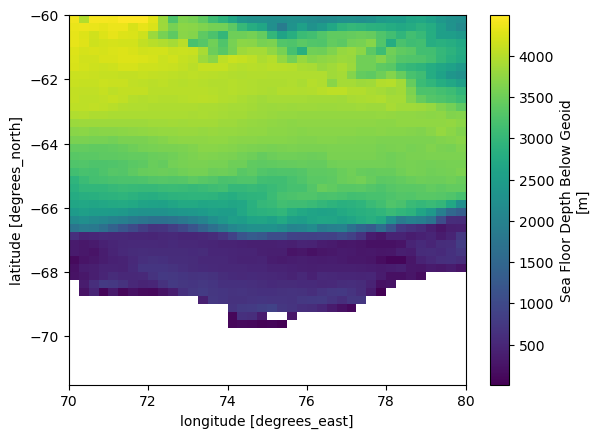

In [5]:
depth = xr.open_zarr(os.path.join(
    base_folder, 
    'gfdl-mom6-cobalt2_obsclim_deptho_15arcmin_fao-58_fixed.zarr/'))['deptho']
# depth = depth.sel(lat = slice(-60, None), lon = slice(70, 80))
depth.plot()

In [6]:
log10_size_bins_mat = xr.open_zarr('outputs/log10_size_bins_matrix.zarr/')['size_bins']
effort = xr.open_zarr(
    os.path.join(base_folder,
                 'effort_15arcmin_fao-58_monthly_1961_2010.zarr/'))['effort']
pref_benthos = xr.open_zarr(
    os.path.join(base_folder, 
                 'pref-benthos_15arcmin_fao-58_fixed.zarr/'))['pref_benthos']
pref_pelagic = xr.open_zarr(
    os.path.join(base_folder, 
                 'pref-pelagic_15arcmin_fao-58_fixed.zarr/'))['pref_pelagic']
constant_growth = xr.open_zarr(
    os.path.join(base_folder,
                 'const-growth_15arcmin_fao-58_fixed.zarr/'))['constant_growth']
constant_mortality = xr.open_zarr(
    os.path.join(base_folder,
                 'const-mort_15arcmin_fao-58_fixed.zarr/'))['constant_mortality']
consume_pelagic = xr.open_zarr(
    os.path.join(base_folder,
                 'consume-pelagic_15arcmin_fao-58_fixed.zarr/'))['consume_pelagic']
consume_benthos = xr.open_zarr(
    os.path.join(base_folder,
                 'consume-benthos_15arcmin_fao-58_fixed.zarr/'))['consume_benthos']
predators = xr.open_zarr(
    os.path.join(base_folder, 
                 'predators_15arcmin_fao-58_monthly_1961_2010.zarr/'))['predators']

detritivores = xr.open_zarr(
    os.path.join(base_folder, 
                 'detritivores_15arcmin_fao-58_monthly_1961_2010.zarr/'))['detritivores']

detritus = xr.open_zarr(
    os.path.join(base_folder, 'detritus_15arcmin_fao-58_monthly_1961_2010.zarr/'))['detritus']

fishing_mort_pred = xr.open_zarr(
    os.path.join(base_folder, 
                 'fish-mort-pred_15arcmin_fao-58_monthly_1961_2010.zarr/'))['fish_mort_pred']

fishing_mort_det = xr.open_zarr(
    os.path.join(base_folder, 
                 'fish-mort-det_15arcmin_fao-58_monthly_1961_2010.zarr/'))['fish_mort_det']

pel_tempeffect = xr.open_zarr(
    os.path.join(base_folder, 'pel-temp-eff_15arcmin_fao-58_monthly_1961_2010.zarr/'))['pel_temp_eff']

ben_tempeffect = xr.open_zarr(
    os.path.join(base_folder, 'ben-temp-eff_15arcmin_fao-58_monthly_1961_2010.zarr/'))['ben_temp_eff']

## Intrinsic natural mortality 

In [7]:
other_mort_det = (gridded_params['natural_mort']*
                  10**(-0.25*log10_size_bins_mat))
other_mort_pred = (gridded_params['natural_mort']*
                   10**(-0.25*log10_size_bins_mat))

### Senescence mortality rate 
These values limit large fishes from building up in the system. This is the same function used in Law et al 2008. Using the parameters chosen in the chunk below, it gives similar M2 values to Hall et al. 2006.

In [8]:
senes_mort_det = (gridded_params['const_senescence_mort']*
                  10**(gridded_params['exp_senescence_mort']*
                       (log10_size_bins_mat-gridded_params['size_senescence'])))
senes_mort_pred = (gridded_params['const_senescence_mort']*
                   10**(gridded_params['exp_senescence_mort']*
                        (log10_size_bins_mat-gridded_params['size_senescence'])))

## Parameters from `sizemodel` function

In [9]:
ERSEM_det_input = False
# temp_effect = True
# use_init = True

In [31]:
log10_size_bins = np.array(gridded_params['log10_size_bins'])
# size of individuals found in the model
size_bin_vals = 10**log10_size_bins_mat
time_init = predators.time.values
log_size_increase = gridded_params['log_size_increase']

In [11]:
#Multipliers that do not require iteration
#Size bin related
size_bin_multi = size_bin_vals*log10_size_increase
ts_size_inc = gridded_params['timesteps_years']/log_size_increase

#To be applied to feeding rates for pelagics and benthic groups
feed_mult_pel = (gridded_params['hr_volume_search']*
                 (10**(log10_size_bins_mat*gridded_params['metabolic_req_pred']))*
                 pref_pelagic)

feed_mult_ben = (gridded_params['hr_volume_search']*
                 (10**(log10_size_bins_mat*gridded_params['metabolic_req_pred']))*
                pref_benthos)

In [12]:
growth_int_pred = xr.zeros_like(predators)
# reprod_pred = xr.zeros_like(predators)
pred_mort_pred = xr.zeros_like(predators)
# tot_mort_pred = xr.zeros_like(predators)

growth_det = xr.zeros_like(detritivores)
# reprod_det = xr.zeros_like(detritivores)
pred_mort_det = xr.zeros_like(detritivores)
# tot_mort_det = xr.zeros_like(detritivores)

In [35]:
out_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/test_run'
os.makedirs(out_folder, exist_ok= True)

# Time loop starts here

In [197]:
for i in range(0, numb_time_steps):
    t = sinking_rate.time[i].values
    ts = time_init[i]
    print(i, t, ts)

0 1961-01-01 00:00:00 1959-12-01T00:00:00.000000000
1 1961-02-01 00:00:00 1960-01-01T00:00:00.000000000
2 1961-03-01 00:00:00 1960-02-01T00:00:00.000000000
3 1961-04-01 00:00:00 1960-03-01T00:00:00.000000000
4 1961-05-01 00:00:00 1960-04-01T00:00:00.000000000
5 1961-06-01 00:00:00 1960-05-01T00:00:00.000000000
6 1961-07-01 00:00:00 1960-06-01T00:00:00.000000000
7 1961-08-01 00:00:00 1960-07-01T00:00:00.000000000
8 1961-09-01 00:00:00 1960-08-01T00:00:00.000000000
9 1961-10-01 00:00:00 1960-09-01T00:00:00.000000000
10 1961-11-01 00:00:00 1960-10-01T00:00:00.000000000
11 1961-12-01 00:00:00 1960-11-01T00:00:00.000000000


In [30]:
i = 0
t = sinking_rate.time[i].values
ts = time_init[i]
pred_short = predators.sel(time = ts)
detrit_short = detritivores.sel(time = ts)
fmp_short = fishing_mort_pred*effort.isel(time = i+1)
fmd_short = fishing_mort_det*effort.isel(time = i+1)

In [32]:
if i+1 < gridded_params['numb_time_steps']:
    new_eff, new_fmp, new_fmd = uf.effort_mortality(pred_short, detrit_short, 
                                                    effort.isel(time = i+1), 
                                                    depth, fmp_short, fmd_short,
                                                    log10_size_bins_mat, 
                                                    gridded_params)

In [37]:
# gridded_params['fish_mort_pred']
new_eff

<xarray.DataArray (lat: 46, lon: 40)> Size: 15kB
dask.array<mul, shape=(46, 40), dtype=float64, chunksize=(46, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 368B -60.12 -60.38 -60.62 ... -70.88 -71.12 -71.38
  * lon      (lon) float64 320B 70.12 70.38 70.62 70.88 ... 79.38 79.62 79.88
    time     object 8B 1961-02-01 00:00:00

In [ ]:
new_eff.to_zarr(
    os.path_join(out_folder,

In [34]:
effort = xr.where(effort.time == effort.time[i+1], 
                  new_eff, effort)
fishing_mort_pred = xr.where(fishing_mort_pred == fishing_mort_pred.time[i+1],
                             new_fmp, fishing_mort_pred)
fishing_mort_det = xr.where(fishing_mort_det == fishing_mort_det.time[i+1],
                             new_fmd, fishing_mort_det)

In [60]:
pred_growth = ((pred_short*log_size_increase).dot(constant_growth).
               rename({'sc': 'size_class'}))*feed_mult_pel
feed_rate_pel = (pel_tempeffect.sel(time = t)*
                 (pred_growth/(1+gridded_params['handling']*pred_growth)))

In [61]:
detrit_growth = ((detrit_short*log_size_increase).dot(constant_growth).
                 rename({'sc': 'size_class'}))*feed_mult_ben
feed_rate_bent = (pel_tempeffect.sel(time = t)*
                  (detrit_growth/(1+gridded_params['handling']*detrit_growth)))

In [65]:
detritus_multiplier = ((1/size_bin_vals)*
                       gridded_params['hr_vol_filter_benthos']*
                       10**(log10_size_bins_mat*
                            gridded_params['metabolic_req_detritivore'])*
                       detritus.sel(time = ts))
feed_rate_det = (ben_tempeffect.sel(time = t)*detritus_multiplier/
                 (1+gridded_params['handling']*detritus_multiplier))

In [68]:
calcs = (gridded_params['growth_prop']*
         (gridded_params['growth_pred']*feed_rate_pel)+
         gridded_params['high_prop']*
         (gridded_params['growth_detritivore']*feed_rate_bent))
growth_int_pred = xr.where(growth_int_pred.time == ts, calcs, 
                           growth_int_pred)

del calcs

In [71]:
if gridded_params['dynamic_reproduction']:
    reprod_pred = (gridded_params['growth_prop']*
                   (1-(gridded_params['growth_pred']+
                       gridded_params['energy_pred']))*
                   feed_rate_pel+gridded_params['growth_prop']*
                   (1-(gridded_params['growth_detritivore']+
                       gridded_params['energy_detritivore']))*
                   feed_rate_bent)
    reprod_pred = (reprod_pred.
                   isel(size_class = slice(gridded_params['ind_min_pred_size']+1,
                                           None)))

In [73]:
sat_pel = xr.where(feed_rate_pel > 0, feed_rate_pel/pred_growth, 0)

In [75]:
calcs = (consume_pelagic*((pred_short*sat_pel*
                           log_size_increase).dot(constant_mortality).
          rename({'sc': 'size_class'})))
pred_mort_pred = xr.where(pred_mort_pred.time == ts, calcs, pred_mort_pred)
del calcs

In [81]:
tot_mort_pred = (pred_mort_pred.sel(time = ts)+
                 pel_tempeffect.sel(time = t)*
                 other_mort_pred+senes_mort_pred+
                 fmp_short).drop_vars('time')

In [83]:
calcs = gridded_params['high_prop']*(gridded_params['growth_detritus']*
                                     feed_rate_det)
growth_det = xr.where(growth_det.time == ts, calcs, growth_det)
del calcs

In [86]:
if gridded_params['dynamic_reproduction']:
    reprod_det = (gridded_params['high_prop']*
                  (1-(gridded_params['growth_detritus']+
                      gridded_params['energy_detritivore']))*
                  feed_rate_det)
    reprod_det = (reprod_det.
                  isel(size_class = slice(gridded_params['ind_min_detritivore_size']+1,
                                          None))).drop_vars('time')

In [89]:
calcs = ((gridded_params['hr_volume_search']*
          (10**(log10_size_bins_mat*
                gridded_params['metabolic_req_detritivore']))*
          pref_benthos)*
         ((detrit_short*log_size_increase).dot(constant_growth).
          rename({'sc': 'size_class'})))
sat_ben = xr.where(feed_rate_bent > 0, feed_rate_bent/calcs, 0)
del calcs

In [91]:
calcs = xr.where(sat_ben > 0, 
                 (consume_benthos*((pred_short*sat_ben*log_size_increase).
                                  dot(constant_mortality).
                                  rename({'sc': 'size_class'}))), 
                 0)

pred_mort_det = xr.where(pred_mort_det.time == ts, calcs, pred_mort_det)
del calcs

In [94]:
tot_mort_det = (pred_mort_det.sel(time = ts)+
                ben_tempeffect.sel(time = t)*
                other_mort_det+senes_mort_det+
                fmd_short).drop_vars('time')

In [96]:
output_w = (det_size_multi*feed_rate_det).sum('size_class')

In [97]:
defbypred = ((gridded_params['defecate_prop']*feed_rate_pel*
             size_bin_vals*pred_short+
             gridded_params['def_low']*feed_rate_bent*
             size_bin_vals*pred_short).
             isel(size_class = slice(gridded_params['ind_min_pred_size'],
                                     None)))

In [100]:
if not ERSEM_det_input:
    if gridded_params['detritus_coupling']:
        input_w = (sinking_rate.sel(time = t)* 
                   ((defbypred*log_size_increase).
                    sum('size_class')+
                    (pel_tempeffect.sel(time = t)*other_mort_pred*
                     pred_size_multi).sum('size_class')+ 
                    (pel_tempeffect.sel(time = t)*senes_mort_pred*
                     pred_size_multi).sum('size_class'))+
                   ((ben_tempeffect.sel(time = t)*other_mort_det*
                     det_size_multi).sum('size_class')+ 
                    (ben_tempeffect.sel(time = t)*senes_mort_det*
                     det_size_multi).sum('size_class')))
    else:
        input_w = ((ben_tempeffect.sel(time = t)*other_mort_det*
                     det_size_multi).sum('size_class')+ 
                    (ben_tempeffect.sel(time = t)*senes_mort_det*
                     det_size_multi).sum('size_class'))
    
    burial = input_w*(0.013+0.53*input_w**2/(7+input_w)**2)
    dW = input_w-(output_w+burial)
    calcs = (detritus.sel(time = ts)+dW*gridded_params['timesteps_years'])
    detritus = xr.where(detritus.time == time_init[i+1], calcs, detritus)
    del calcs

In [103]:
ggp_shift = growth_int_pred.sel(time = ts).shift({'size_class': 1})
ggp_shift, range_sc = xr.align(ggp_shift, 
                               log10_size_bins_mat.
                               isel(size_class = gridded_params['idx']))
Ai_u = (((1/np.log(10))*-ggp_shift*ts_size_inc).
        reindex(size_class = log10_size_bins_mat, fill_value = 0)).drop_vars('time')

Bi_u = ((1+(1/np.log(10))*
         (growth_int_pred.isel(size_class = gridded_params['idx'], 
                               time = i))*ts_size_inc+
         tot_mort_pred.isel(size_class = gridded_params['idx'])*
         gridded_params['timesteps_years']).
        reindex(size_class = log10_size_bins_mat, 
                fill_value = 0)).drop_vars('time')

Si_u = ((pred_short.isel(size_class = gridded_params['idx'])).
        reindex(size_class = log10_size_bins_mat, fill_value = 0)).drop_vars('time')

In [119]:
Ai_u = xr.where(Ai_u.size_class == gridded_params['log10_ind_min_pred_size'],
                0, Ai_u)
Bi_u = xr.where(Bi_u.size_class == gridded_params['log10_ind_min_pred_size'],
                1, Bi_u)

In [135]:
calc = (pred_short.isel(size_class = gridded_params['ind_min_pred_size'])+
             ((reprod_pred*size_bin_vals*pred_short*log_size_increase).
              sum('size_class')*
              gridded_params['timesteps_years'])/
             (size_bin_multi.
              isel(size_class = gridded_params['ind_min_pred_size']))-
             ts_size_inc*(1/np.log(10))*
             (growth_int_pred.isel(time = i, 
                                   size_class = gridded_params['ind_min_pred_size']))*
             pred_short.isel(size_class = gridded_params['ind_min_pred_size'])-
             gridded_params['timesteps_years']*
             (tot_mort_pred.isel(size_class = gridded_params['ind_min_pred_size']))*
             (pred_short.isel(size_class = gridded_params['ind_min_pred_size'])))


In [139]:
if gridded_params['dynamic_reproduction']:
    calc = (pred_short.isel(size_class = gridded_params['ind_min_pred_size'])+
             ((reprod_pred*size_bin_vals*pred_short*log_size_increase).
              sum('size_class')*
              gridded_params['timesteps_years'])/
             (size_bin_multi.
              isel(size_class = gridded_params['ind_min_pred_size']))-
             ts_size_inc*(1/np.log(10))*
             (growth_int_pred.isel(time = i, 
                                   size_class = gridded_params['ind_min_pred_size']))*
             pred_short.isel(size_class = gridded_params['ind_min_pred_size'])-
             gridded_params['timesteps_years']*
             (tot_mort_pred.isel(size_class = gridded_params['ind_min_pred_size']))*
             (pred_short.isel(size_class = gridded_params['ind_min_pred_size'])))

    calc = calc.drop_vars(('time', 'size_class'))

    predators = xr.where(
        (predators.size_class == gridded_params['log10_ind_min_pred_size']) &
        (predators.time == time_init[i+1]), calc, predators)

    del calc

In [142]:
range_sc = (log10_size_bins_mat.
            isel(size_class = slice(gridded_params['ind_min_pred_size']+1,
                                    None)))
pred_next = predators.isel(time = i+1).shift({'size_class': 1}).drop_vars('time')
pred_next, range_sc = xr.align(pred_next, range_sc)
calc = (((Si_u.sel(size_class = range_sc)-Ai_u.sel(size_class = range_sc)*
          pred_next)/Bi_u.sel(size_class = range_sc)).
        reindex(size_class = log10_size_bins_mat, fill_value = 0))
predators = xr.where((predators.time == time_init[i+1]) &
                     (predators.size_class >= 
                      log10_size_bins[gridded_params['ind_min_pred_size']+1]) &
                     (predators.size_class <= max(log10_size_bins)), 
                     calc, predators)

del calc

In [143]:
ggp_shift = growth_det.sel(time = ts).shift({'size_class': 1})
ggp_shift, range_sc = xr.align(ggp_shift, 
                               log10_size_bins_mat.
                               isel(size_class = gridded_params['idx_new']))

Ai_v = (((1/np.log(10))*-ggp_shift*ts_size_inc).
        reindex(size_class = log10_size_bins_mat, fill_value = 0)).drop_vars('time')

Bi_v = ((1+(1/np.log(10))*growth_det.isel(size_class = gridded_params['idx_new'],
                                          time = i)*
         ts_size_inc+
         tot_mort_det.isel(size_class = gridded_params['idx_new'])*
         gridded_params['timesteps_years']).
        reindex(size_class = log10_size_bins_mat, fill_value = 0)).drop_vars('time')

Si_v = (detrit_short.isel(size_class = gridded_params['idx_new']).
        reindex(size_class = log10_size_bins_mat, fill_value = 0)).drop_vars('time')

In [144]:
Ai_v = xr.where(Ai_v.size_class == gridded_params['log10_ind_min_detritivore_size'],                
                0, Ai_v)

Bi_v = xr.where(Bi_v.size_class == gridded_params['log10_ind_min_detritivore_size'],
                1, Bi_v)

In [145]:
calc = detritivores.sel(time = ts).drop_vars('time')
detritivores = xr.where(
    (detritivores.size_class >= detritivores.size_class.min()) & 
    (detritivores.size_class <= gridded_params['log10_ind_min_detritivore_size']) & 
    (detritivores.time == time_init[i+1]), calc, detritivores)
del calc

In [148]:
if gridded_params['dynamic_reproduction']:
    calc = (detrit_short.
            isel(size_class = gridded_params['ind_min_detritivore_size'])+
             ((reprod_det*size_bin_vals*detrit_short*log_size_increase).
              sum('size_class')*
              gridded_params['timesteps_years'])/
             size_bin_multi.
              isel(size_class = gridded_params['ind_min_detritivore_size'])-
             ts_size_inc*(1/np.log(10))*
             (growth_det.isel(time = i, 
                              size_class = gridded_params['ind_min_detritivore_size']))*
             (detrit_short.
              isel(size_class = gridded_params['ind_min_detritivore_size']))-
             gridded_params['timesteps_years']*
             (tot_mort_det.
              isel(size_class = gridded_params['ind_min_detritivore_size']))*
             (detrit_short.
              isel(size_class = gridded_params['ind_min_detritivore_size'])))
    
    calc = calc.drop_vars(('time', 'size_class'))

    detritivores = xr.where(
        (detritivores.size_class == gridded_params['log10_ind_min_detritivore_size']) &
        (detritivores.time == time_init[i+1]), calc, detritivores)

    del calc

In [149]:
det_next = detritivores.isel(time = i+1).shift({'size_class': 1}).drop_vars('time')
det_next, range_sc = xr.align(det_next, range_sc)
calc = (((Si_v.sel(size_class = range_sc)-Ai_v.sel(size_class = range_sc)*
          det_next)/Bi_v.sel(size_class = range_sc)).
        reindex(size_class = log10_size_bins_mat, fill_value = 0))
detritivores = xr.where(
    (detritivores.time == time_init[i+1]) &
    (detritivores.size_class >= 
     log10_size_bins[gridded_params['ind_min_detritivore_size']+1]) &
    (detritivores.size_class <= max(log10_size_bins)),
    calc, detritivores)
del calc

## Outside time loop

### Fisheries catches per year per size class
`fishing_mort_pred` and `fishing_mort_det` are set to zero outside the sizes for each class, so there is no need to apply a mask here.

In [356]:
catch_pred = fishing_mort_pred*predators*size_bin_vals
catch_det = fishing_mort_det*detritivores*size_bin_vals